<h2 id='part1'>Project 1: Blog</h2>
Looking into the population of the stack Overflow data, I wanted to look at the differences between men and women.


__The questions that I want to answer are:__
<br> a) How big is the disparity in pay between men and women?
<br> b) How does having children impact progression?
<br> c) Women in STEM… Is there really an obstacle? (i.e is it harder for women to break into?)

I thought a good place to start was looking at the what the breakdown of the population was by gender.
For that I needed to read in the data:
 
 
 Licence info:
This database - The Public 2018 Stack Overflow Developer Survey Results - is made available under the Open Database License (ODbL): http://opendatacommons.org/licenses/odbl/1.0/. Any rights in individual contents of the database are licensed under the Database Contents License: http://opendatacommons.org/licenses/dbcl/1.0/


In [1]:
#importing pakcages needed for the project

import numpy as np
import pandas as pd

import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
%matplotlib inline


#Reading in the StackOverflow Developer Survey data
file_path = os.path.join(os.getcwd(),r"StackOverflow_Data\2018\survey_results_public.csv")

df=pd.read_csv(file_path)


#Selecting columns needed for the analysis - started with just Gender and added these slowly as my analysis below needed.
cols = ['CareerSatisfaction','JobSatisfaction', 'CompanySize',
        'Country','Gender','Age','ConvertedSalary',
        'UndergradMajor','YearsCoding','Dependents']


df_personal = df[cols]


C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
#Outputting metrics on gender breakdown

#Defined a function to convert multiple choice columns into a usable output
def split_and_stack(df_orig, col, sep):
    
    """This splits multiple choice answers within a column into multiple columns, then converts them back into extra rows
    so each option selected by 1 user will be on a new row, meaning that the popultion can be analysed.
    
    Steps:
    1) Splits a single column in a dataframe into multiple columns (/levels), using a defined seperator.
    2) Stacks these extra column entries into rows, but shows indexes of extra levels which the data was split over.
    3) Extra levels / generated columns are then dropped.
    4) Renames the last column as the Orignal column name.
    
    Parameters:
    df_orig (pandas.DataFrame): A DataFrame containing columns with multiple choice answers.
    col (string): The column which requires multiple choice answers to be split.
    sep (string): The seperator which the column (col) mentioned above needs to be split over.

    Returns:
    pandas.DataFrame:Returning a DataFrame of the total population with extra rows (multiple for the same index) 
    for multiple choice responses.
    
    """
    new_df = df_orig[col].str.split(sep,expand=True).stack().to_frame().reset_index()
    new_df = new_df.drop(['level_0','level_1'], axis=1)
    new_df.columns = [col]
    
    return new_df


#splitting the data into usable rows, see function defined above (preparing the data)
df_gender = split_and_stack(df_personal, 'Gender', ';')


#Grouping by and calculating Gender breakdowns. 
#Groupby disregards null Gender values so these are removed, don't want to see them as doesn't give us information about gende rpopulation
gender = df_gender.groupby('Gender')['Gender'].count().sort_values(ascending=False)/len(df_gender)
gender_stats = zip(list(gender.index),list(gender))


#Printing stats in percentage form
for gender in gender_stats:
    print(gender[0] + ": " +"{:.2%}".format(gender[1]))
    


Male: 91.68%
Female: 6.76%
Non-binary, genderqueer, or gender non-conforming: 0.91%
Transgender: 0.65%


### Question 1: How big is the disparity in pay between men and women?
Looking at the stark differences in population size, I wondered what else was different about the populations between men and women.
Something regularly in the media, the gender pay gap, can be detrimental to the view of professions / businesses and I wanted to assess how big the impact on pay is.

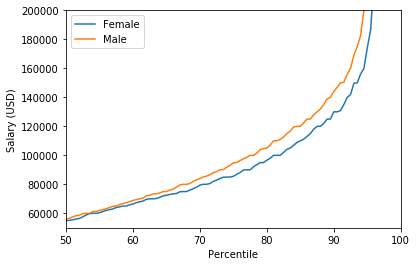

In [3]:
#Outputting graph to highlight salary differences by percentile.

#Splitting data to male only and female only as population sizes are significantly different.

#Null values for Gender are removed as we don't know their gender and could skew the results.
#Moreover, imputing values wouldn't make sense, we could only use the mode which would just be classifying them all as male.
df_male = df_personal.dropna(subset=['Gender'], axis=0)[df_personal.Gender.dropna(axis=0).\
                               apply(lambda x: True if 'Male' in x else False)]

df_female = df_personal.dropna(subset=['Gender'],axis=0)[df_personal.Gender.dropna(axis=0).\
                                 apply(lambda x: True if 'Female' in x else False)]

    
#Finding percentiles of salary for male and female.
#THe Quantile function ignores nulll values for ConvertedSalary. If we imputed values, i.e replace null with mean/median)
#then this would potentially skew the results and change the distribution below.
female_percentiles = [ (i*100, df_female.ConvertedSalary.quantile(i)) for i in np.arange(0,1,0.005) ]
male_percentiles = [ (i*100, df_male.ConvertedSalary.quantile(i)) for i in np.arange(0,1,0.005) ]


#Separating x and y values for the graph
x_female_percentile = [x[0] for x in female_percentiles]
y_female_percentile = [y[1] for y in female_percentiles]

x_male_percentile = [x[0] for x in male_percentiles]
y_male_percentile = [y[1] for y in male_percentiles]


#setting graph limits x and y limits and labelling axis
plt.ylim((50000,200000))
plt.ylabel('Salary (USD)')
plt.xlabel('Percentile')
plt.xlim((50,100))

plt.plot(x_female_percentile, y_female_percentile, label = 'Female')
plt.plot(x_male_percentile, y_male_percentile, label = 'Male')
plt.legend(loc='upper left', prop={'size':10})

#Saving file
plt.savefig(os.path.join(os.getcwd(),'Pay_gap.png'),bbox_inches='tight')

It is clear from the graph below that there is a significant difference between men and women in high paying roles.
<br>
<br> This prompted another question, if women are paid less, does this affect their satisfaction in their current role?

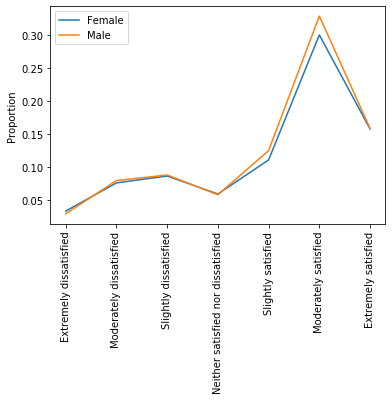

In [4]:
#Outputting graph of job satisfaction by gender

#Re-casting the JobSatisfaction to Ordered Category as this data is ordered and is needed to correctly order the output
df_male['JobSatisfaction']=df_male['JobSatisfaction']\
                                    .astype(pd.api.types.CategoricalDtype(
                                            categories=['Extremely dissatisfied','Moderately dissatisfied',
                                                        'Slightly dissatisfied','Neither satisfied nor dissatisfied',
                                                        'Slightly satisfied','Moderately satisfied','Extremely satisfied'],
                                            ordered=True))

df_female['JobSatisfaction']=df_female['JobSatisfaction']\
                                    .astype(pd.api.types.CategoricalDtype(
                                            categories=['Extremely dissatisfied','Moderately dissatisfied',
                                                        'Slightly dissatisfied','Neither satisfied nor dissatisfied',
                                                        'Slightly satisfied','Moderately satisfied','Extremely satisfied'],
                                            ordered=True))

    
#Finding percentage breakdown for career satisfaction. Count/Groupby function ignores nulll values for CareerSatisfaction
#Since we just want population distribution, it makes sense to ignore these.
female_job_sat = df_female.groupby('JobSatisfaction').JobSatisfaction.count().sort_index()/len(df_female)
male_job_sat = df_male.groupby('JobSatisfaction').JobSatisfaction.count().sort_index()/len(df_male)


#Formatting and generating a graph
plt.ylabel('Proportion')
plt.xticks(rotation=90)

plt.plot(list(female_job_sat.index), list(female_job_sat), label = 'Female')
plt.plot(list(male_job_sat.index), list(male_job_sat), label = 'Male')
plt.legend(loc='upper left', prop={'size':10})

plt.savefig(os.path.join(os.getcwd(),'Gender_job_satisfaction.png'),bbox_inches='tight')

Even though the above indicates men may be slightly more satisfied with their jobs, the distribtuion is generally the same and I would say satisfaction for both genders is pretty similar.
<br>
<br> This didn't seem intuitive to me, so I explicitly looked at the salaries by Job Satisfaction for both genders to get a better understanding.

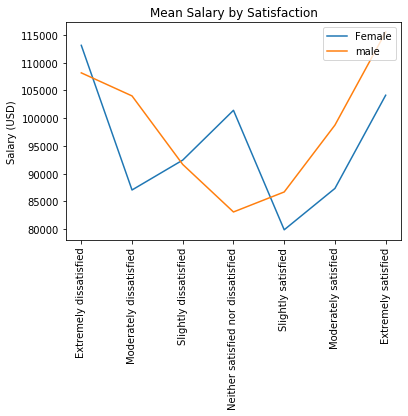

In [5]:
#Outputting a graph of the salary for men and women by job satisfaction breakdown

#Mean function ignores nulll values for ConvertedSalary. Groupby function ignores nulll values for CareerSatisfaction.

#Since we want mean Salary values, imputing median may skew this figure with large numbers of nulls and mean wouldn't affect this, so ignoring.
#We also want this figure to be consistent with graph above, so not imputing JobSatisfaction values.
female_job_sat_mean = df_female.groupby('JobSatisfaction').ConvertedSalary.mean().sort_index()
male_job_sat_mean = df_male.groupby('JobSatisfaction').ConvertedSalary.mean().sort_index()


#Formatting and generating a graph
plt.title('Mean Salary by Satisfaction')
plt.ylabel('Salary (USD)')
plt.xticks(rotation=90)

plt.plot(list(female_job_sat_mean.index), list(female_job_sat_mean), label = 'Female')
plt.plot(list(male_job_sat_mean.index), list(male_job_sat_mean), label = 'male')

plt.legend(loc='upper right', prop={'size':10})
plt.savefig(os.path.join(os.getcwd(),'Gender_pay_by_Satisfaction.png'),bbox_inches='tight')

The above graph illustrates that salary and JobSatisfaction are not directly correlated, if anything, it suggested higher paid professionals may actually dislike their jobs more!
<br>
<br> To explain why salaries may be different between men and women, as discovered above, I thought looking into the experience of the individuals would be a better indicator.

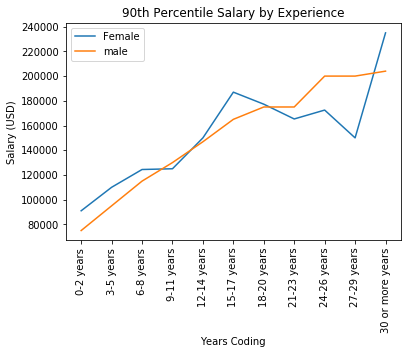

In [6]:
#Outputting graph of men and women's 90th percentile salaries by years of experience,

#Groupby function ignores null values in YearsCoding, quantile function ignores nulll values for ConvertedSalary
#If we imputed the converted salary values, this may shift the distribution, so these are ignored.
#Years coding is directly related with age and it may be non-sensical to impute values as this relationship wouldnt be preserved.
female_exp_sal = df_female.groupby('YearsCoding').ConvertedSalary.quantile(0.9)
male_exp_sal = df_male.groupby('YearsCoding').ConvertedSalary.quantile(0.9)


#Ordering points for graph so it's in Experience ascending order
female_exp_sal_sort = sorted(list(zip(female_exp_sal.index, female_exp_sal)),key = lambda x: int(x[0].split()[0].split('-')[0]))
male_exp_sal_sort = sorted(list(zip(male_exp_sal.index, male_exp_sal)),key = lambda x: int(x[0].split()[0].split('-')[0]))


#Separating x and y values for the graph
x_female_exp_sal = [x[0] for x in female_exp_sal_sort]
y_female_exp_sal = [y[1] for y in female_exp_sal_sort]
x_male_exp_sal = [x[0] for x in male_exp_sal_sort]
y_male_exp_sal = [y[1] for y in male_exp_sal_sort]


#Formatting and generating a graph
plt.title('90th Percentile Salary by Experience')
plt.ylabel('Salary (USD)')
plt.xlabel('Years Coding')
plt.xticks(rotation=90)

plt.plot(x_female_exp_sal, y_female_exp_sal, label = 'Female')
plt.plot(x_male_exp_sal, y_male_exp_sal, label = 'male')

plt.legend(loc='upper left', prop={'size':10})
plt.savefig(os.path.join(os.getcwd(),'90thpercentile_pay_gap_exp.png'),bbox_inches='tight')


As expected, the graph above shows how closely correlated experience and salary are. 
<br>There didn't seem to be a huge difference in this correlation between men and women, so it doesn't really explain why there were bigger pay differences in these higher percentiles.
<br>
<br> I decided to look at the breakdown of the population by experience, to shed some light on why their salaries may be different:

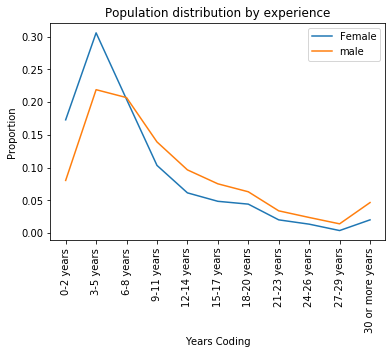

In [7]:
#Outputting graph of male and female population by age. 

#Count & Groupby ignores null values in YearsCoding
#YearsCoding is directly correlated with age, so imputing values will not preserve this relationship
female_exp = df_female.groupby('YearsCoding').YearsCoding.count()/len(df_female)
male_exp = df_male.groupby('YearsCoding').YearsCoding.count()/len(df_male)


#Ordering points for graph so it's in Experience ascending order
female_exp_sort = sorted(list(zip(female_exp.index, female_exp)),key = lambda x: int(x[0].split()[0].split('-')[0]))
male_exp_sort = sorted(list(zip(male_exp.index, male_exp)),key = lambda x: int(x[0].split()[0].split('-')[0]))


#Separating x and y values for the graph
x_female_exp = [x[0] for x in female_exp_sort]
y_female_exp = [y[1] for y in female_exp_sort]
x_male_exp = [x[0] for x in male_exp_sort]
y_male_exp = [y[1] for y in male_exp_sort]


#Formatting and generating a graph
plt.title('Population distribution by experience')
plt.ylabel('Proportion')
plt.xlabel('Years Coding')
plt.xticks(rotation=90)

plt.plot(x_female_exp, y_female_exp, label = 'Female')
plt.plot(x_male_exp, y_male_exp, label = 'male')

plt.legend(loc='upper right', prop={'size':10})
plt.savefig(os.path.join(os.getcwd(),'Gender_exp_pop_dist.png'),bbox_inches='tight')


As can be seen, the Female population is skewed to the left, meaning that there is a significantly greater proportion of more junior coders, potentially explaining why there is a disparity in pay.
<br>
<br> TO be sure that this is the case, I wanted to look at the difference in mean pay for these as well, to understand better the overall correlation between Coding experience and salary

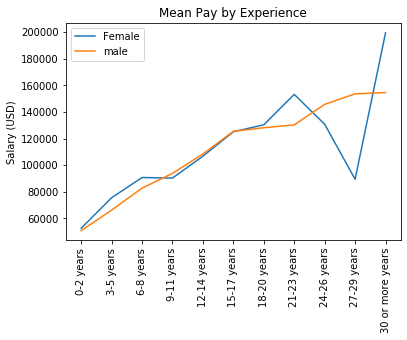

In [8]:
#Calculating & Outputting graph of population distribution by years of experience. 

#Mean function ignores nulll values for ConvertedSalary, Groupby ignores null values in YearsCoding
#Doesn't make sense to impute the values here, as Age and Years Coding are implicitly linked and
#imputing mean values for Salary wouldn't change our findings (as we are taking the mean)
female_sal_exp_mean = df_female.groupby('YearsCoding').ConvertedSalary.mean()
male_sal_exp_mean = df_male.groupby('YearsCoding').ConvertedSalary.mean() 


#Ordering points for graph so it's in Experience ascending order
female_sal_exp_mean_sort = sorted(list(zip(female_sal_exp_mean.index, female_sal_exp_mean)),key = lambda x: int(x[0].split()[0].split('-')[0]))
male_sal_exp_mean_sort = sorted(list(zip(male_sal_exp_mean.index, male_sal_exp_mean)),key = lambda x: int(x[0].split()[0].split('-')[0]))


#Separating x and y values for the graph
x_female_mean_sal_exp = [x[0] for x in female_sal_exp_mean_sort]
y_female_mean_sal_exp = [y[1] for y in female_sal_exp_mean_sort]
x_male_mean_sal_exp = [x[0] for x in male_sal_exp_mean_sort]
y_male_mean_sal_exp = [y[1] for y in male_sal_exp_mean_sort]


#Formatting and generating a graph
plt.title('Mean Pay by Experience')
plt.ylabel('Salary (USD)')
plt.xticks(rotation=90)

plt.plot(x_female_mean_sal_exp, y_female_mean_sal_exp, label = 'Female')
plt.plot(x_male_mean_sal_exp, y_male_mean_sal_exp, label = 'male')

plt.legend(loc='upper left', prop={'size':10})
plt.savefig(os.path.join(os.getcwd(),'MedianPay_by_Exp.png'),bbox_inches='tight')

In general,the correlation of experience and salary holds true, giving a good explanation for why women's salries may be lower, as there's more junior people.
<br>
<br> However, there is an exception for the age bracket 24-29 years. THis could be put down to sample size, but it could symptomatic of issues women face around these years. Moreover, someone with 24-29 years of coding experiences are likely to be around 50 years old. This lead me to investigate into a different area of which women of this age may have been challenged with....

<h2 id='part1'>Question 2: How does having children impact progression?</h2>
<br>
Typically, women have longer a longer absence from work due to maternity leave and undertake more of the care-giving role than men. I wanted to see if having children, had a significant impact on their progression. One way of measuring progression is salary, which is what I have focussed on below.
    

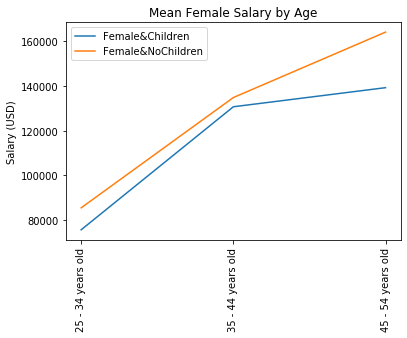

In [9]:
#Outputting graph to show female salary differences witgh and without children, by age

#We are only interested in looking at population who answered the dependency question and the salary question.
#Therefore, dropping values where people haven't answered these questions as it won't inform outcome
df_dep_no_null_f = df_female.dropna(subset=['Dependents','ConvertedSalary'],how='any')
df_dep_no_null_m = df_male.dropna(subset=['Dependents','ConvertedSalary'],how='any')


#Filtering for ages most likley children are to have an impact on salary.
#Women tend to retire earlier than men and under 25s are unlikely to have children, potentially not have a salary either.
#Therefore, they have been removed
ages_for_children = ['25 - 34 years old','35 - 44 years old','45 - 54 years old']

df_dependents_f=df_dep_no_null_f[df_dep_no_null_f.Age.apply(lambda x: True if x in ages_for_children else False)]
df_dependents_m=df_dep_no_null_m[df_dep_no_null_m.Age.apply(lambda x: True if x in ages_for_children else False)]


#Finding average Salaries by age and by dependents status
#Groupby removes nulls for Age, since we want to find out affects over age bands, these values have been dropped.
female_sal_series = df_dependents_f.groupby(['Dependents','Age']).ConvertedSalary.mean().sort_index()
male_sal_series = df_dependents_m.groupby(['Dependents','Age']).ConvertedSalary.mean().sort_index()


#Formatting and generating a graph
plt.plot(list(female_sal_series['Yes'].index), list(female_sal_series['Yes']), label='Female&Children')
plt.plot(list(female_sal_series['No'].index), list(female_sal_series['No']), label='Female&NoChildren')

plt.title("Mean Female Salary by Age")
plt.ylabel('Salary (USD)')
plt.xticks(rotation=90)
plt.legend()

plt.savefig(os.path.join(os.getcwd(),'FemalePay_by_age&dependents.png'),bbox_inches='tight')


As you can see, the graph above indicates having children has a significant impact on women's salaries, especially later in life.
<br>
<br> I wanted to evaluate how much of an impact it actually has, and how this is different from men.

In [10]:
#Outputting/ Calculating the relative differences in salaries with and without children
female_dep_cost = female_sal_series['Yes']/female_sal_series['No']
male_dep_cost = male_sal_series['Yes']/male_sal_series['No']


#Combining the results into one dataframe for output
df_dep_cost = pd.concat([pd.DataFrame(list(female_dep_cost), index = list(female_dep_cost.index), columns = ['Female']),
                        pd.DataFrame(list(male_dep_cost), index = list(male_dep_cost.index),columns=['Male'])],axis=1)


#Reformatting the data to be percentage change and in percentage format
df_dep_cost['Female'] = df_dep_cost['Female'].apply(lambda x: "{:.2%}".format(x-1))
df_dep_cost['Male'] = df_dep_cost['Male'].apply(lambda x: "{:.2%}".format(x-1))

df_dep_cost

,Female,Male
25 - 34 years old,-11.47%,-1.83%
35 - 44 years old,-3.05%,3.65%
45 - 54 years old,-15.13%,-3.78%


Clearly, from the above, men's income is much more stable when it comes to having children. Moreover, the magnitude of the difference is significant. Women can expect to have a large earnings hit if they have children.

It is worth noting, that the stabilitiy __may__ be due to an increase in population size, but it's difficult to determine this effect.

<h2 id='part1'>Question 3: Women in STEM… Is there really an obstacle??</h2>
<br>
Furthering from the differences in having children, I wanted to see if there were any other drivers of why older women may have a lower salary.
<br>
<br> I started to think about generational difference and how women were less likely to have higher education, but also less likely to pursue STEM subjects. In recent years, there are lots of initiative to increase women's participation in STEM subjects and I wanted to see what the impact of this was. I started with the interest in Computer Science / Technical degree as the dataset is relating to Developers:
    

In [11]:
#Calculating total proportion of Computer Science related degrees for each gender

#Adding flags for technical degrees. Looking at the data, people with a technical background with the below Majors
#would be better equipped for a future in computer science/ a developer role
technical_degree = ['Computer science, computer engineering, or software engineering',
                   'Information systems, information technology, or system administration'
                   'Web development or web design']


#Dropping entries with NaNs for undergrad major, otherwise we would be assuming they were 'Non-Technical'
#for all nulls in the population which would skew the results. Moreover, removing nulls also removes those who didn't
#go to university. Since we are considering those with technical degrees, we want to remove these people from our population
df_female_grad = df_female.dropna(subset=['UndergradMajor'],axis=0)
df_male_grad = df_male.dropna(subset=['UndergradMajor'],axis=0)

df_female_grad['TechnicalDegree'] = df_female_grad.UndergradMajor\
                                    .apply(lambda x : 'Technical' if x in technical_degree else 'Non-Technical')
df_male_grad['TechnicalDegree'] = df_male_grad.UndergradMajor\
                                    .apply(lambda x : 'Technical' if x in technical_degree else 'Non-Technical')


#Finding the number of technical vs non-technical people in population by Gender
female_tech_bd = df_female_grad.groupby('TechnicalDegree').TechnicalDegree.count()/len(df_female_grad)
male_tech_bd = df_male_grad.groupby('TechnicalDegree').TechnicalDegree.count()/len(df_male_grad)


#Formatting and printing the output
print('Women with a Computer Science related degree: ' + "{:.2%}".format(female_tech_bd['Technical']))
print('Men with a Computer Science related degree: ' + "{:.2%}".format(male_tech_bd['Technical']))


Women with a Computer Science related degree: 54.19%
Men with a Computer Science related degree: 63.84%


C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


From a first glance at the data, it is clear that there are more men with technical degrees which indicates a bias in their education to technical fields.
<br>
<br> Exploring this further...

Women, 35 and over: 7.03%
Men, 35 and over: 12.57%
Women, 18 to 34: 38.72%
Men, 18 to 34: 41.05%


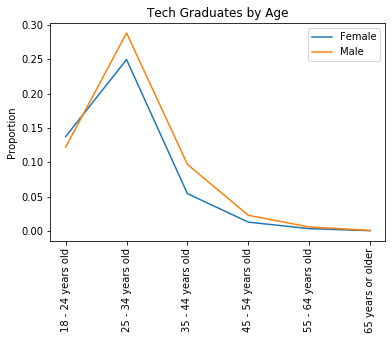

In [12]:
#Outputting graph showing the age distribution of graduates.

#Filtering list to only Technical people to show age distribution of this
df_female_tech = df_female_grad[df_female_grad['TechnicalDegree']=='Technical']
df_male_tech = df_male_grad[df_male_grad['TechnicalDegree']=='Technical']


#Filtering age to that of graduate ages, as we are considering Undergraduate Majors
over_35 = ['35 - 44 years old','45 - 54 years old','55 - 64 years old','65 years or older']
under_25 = ['25 - 34 years old','18 - 24 years old']
graduate_ages = under_25 + over_35


#Groupby removes nulls for Age, since we want to find distribution of age bands, these values have been dropped.
#Imputing these values may skew the distribution
female_tech_bd_age = df_female_tech.groupby('Age')['Age'].count()[graduate_ages].sort_index()/len(df_female) #_tech
male_tech_bd_age = df_male_tech.groupby('Age')['Age'].count()[graduate_ages].sort_index()/len(df_male)


##Printing statistics for reference in blog, age and gender differences in population
print('Women, 35 and over: ' + "{:.2%}".format(female_tech_bd_age[over_35].sum()))
print('Men, 35 and over: ' + "{:.2%}".format(male_tech_bd_age[over_35].sum()))
print('Women, 18 to 34: ' + "{:.2%}".format(female_tech_bd_age[under_25].sum()))
print('Men, 18 to 34: ' + "{:.2%}".format(male_tech_bd_age[under_25].sum()))


#Formatting and generating a graph
plt.plot(list(female_tech_bd_age.index), list(female_tech_bd_age), label='Female')
plt.plot(list(male_tech_bd_age.index), list(male_tech_bd_age), label='Male')

plt.title("Tech Graduates by Age")
plt.ylabel('Proportion')
plt.xticks(rotation=90)
plt.legend()

plt.savefig(os.path.join(os.getcwd(),'Tech_grads_by_age.png'),bbox_inches='tight')


It is clear that men favoured technical subjects from age 25 and above, putting women at a disadvantage for developer roles. However, it can also be seen that for the youngest age bracket, there has been a switch in the proportion of men and women exploring these options, with women now pursuing technical subjects more than men.
<br>
<br> I wanted to have a deeper look into Undergrad Majors because many people in the survey did not have these degrees (i.e 35% men, 45% of women). STEM subjects are closely linked to developer roles and I wanted to have a wider understanding of educational bias.

In [13]:
#Calculating total proportion of STEM related degrees for each gender

#Adding a flag for STEM subjects and repeating the analysis above
#Note: still only taking the graduate population, as above.
non_STEM = ['Fine arts or performing arts (ex. graphic design, music, studio art)',
            'A social science (ex. anthropology, psychology, political science)',
            'A humanities discipline (ex. literature, history, philosophy)',
            'A business discipline (ex. accounting, finance, marketing)',
            'I never declared a major']

df_female_grad['STEM'] = df_female_grad.UndergradMajor\
                                    .apply(lambda x : 'Non-STEM' if x in non_STEM else 'STEM')
df_male_grad['STEM'] = df_male_grad.UndergradMajor\
                                    .apply(lambda x : 'Non-STEM' if x in non_STEM else 'STEM')


##Printing statistics for reference in blog, gender &STEM differences in population
print("Women in STEM: {:.2%}".format(df_female_grad.groupby('STEM').STEM.count()['STEM']/len(df_female_grad)))
print("Men in STEM: {:.2%}".format(df_male_grad.groupby('STEM').STEM.count()['STEM']/len(df_male_grad)))

Women in STEM: 82.32%
Men in STEM: 91.66%


C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\dltheobald\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


From a first glance at the data, it is clear that there are more men with STEM degrees which indicates a bias in their education to technical fields.
<br>
<br> Exploring this further...

In [14]:
#Calculating the population distribution of STEM related degrees for each gender by age

#Filtering out stem graduates only as we want to look at the demographics of this.
df_female_STEM = df_female_grad[df_female_grad['STEM']=='STEM']
df_male_STEM = df_male_grad[df_male_grad['STEM']=='STEM']


#Only considering working professionals as they are most likely to have degrees and be in employment
#People below these ages are unlikely to have a degree and it would be non-sensical.
working_professionals = ['18 - 24 years old','25 - 34 years old','35 - 44 years old',
                         '45 - 54 years old','55 - 64 years old']


#Groupby and Count removes Nulls from calculation. We don;t want to impute these values as is may skew the population distribution
female_STEM_bd_age = df_female_STEM.groupby('Age')['Age'].count()[working_professionals]/len(df_female_STEM)
male_STEM_bd_age = df_male_STEM.groupby('Age')['Age'].count()[working_professionals]/len(df_male_STEM)


#Combining data together into one DataFrame
df_STEM_bd = pd.concat([pd.DataFrame(list(female_STEM_bd_age), index = list(female_STEM_bd_age.index), columns = ['Female']),
                        pd.DataFrame(list(male_STEM_bd_age), index = list(male_STEM_bd_age.index),columns=['Male'])],axis=1)


#Reformatting data into percentages to 2dp.
df_STEM_bd['Female'] = df_STEM_bd['Female'].apply(lambda x: "{:.2%}".format(x))
df_STEM_bd['Male'] = df_STEM_bd['Male'].apply(lambda x: "{:.2%}".format(x))
df_STEM_bd

,Female,Male
18 - 24 years old,26.73%,20.62%
25 - 34 years old,53.18%,52.50%
35 - 44 years old,12.73%,18.32%
45 - 54 years old,3.36%,5.12%
55 - 64 years old,1.11%,1.44%


Looking at population distribution of STEM graduates, this information does show a preferene for the younger generation to take this subjects. __However__, this data is skewed by the fact the majority of respondents were in the lower age ranges, meaning this doesn't give us as much information as initially though.
<br>
<br> As a result, looking at the breakdowns of the population for each age group would be more indicative.

In [15]:
#Calculating the STEM percentage for EACH age group, by gender

#Groupby removes nulls for Age, since we want to find STEM distributions forr age bands, we don't want to impute these value.
#Otherwise, it may skew the distribution
STEM_count_f = df_female_grad.groupby(['STEM','Age']).STEM.count()['STEM'][working_professionals]
STEM_count_f_total = df_female_grad.groupby('Age').STEM.count()[working_professionals]

STEM_count_m = df_male_grad.groupby(['STEM','Age']).STEM.count()['STEM'][working_professionals]
STEM_count_m_total = df_male_grad.groupby('Age').STEM.count()[working_professionals]


##Calculating the STEM population percentage by age
STEM_bd_female = STEM_count_f/STEM_count_f_total
STEM_bd_male = STEM_count_m/STEM_count_m_total


#Combining data together into one DataFrame
df_STEM_bd_2 = pd.concat([pd.DataFrame(list(STEM_bd_female), index = list(STEM_bd_female.index), columns = ['Female']),
                        pd.DataFrame(list(STEM_bd_male), index = list(STEM_bd_male.index),columns=['Male'])],axis=1)


#Reformatting data into percentages to 2dp.
df_STEM_bd_2['Female'] = df_STEM_bd_2['Female'].apply(lambda x: "{:.2%}".format(x))
df_STEM_bd_2['Male'] = df_STEM_bd_2['Male'].apply(lambda x: "{:.2%}".format(x))
df_STEM_bd_2

,Female,Male
18 - 24 years old,93.36%,96.33%
25 - 34 years old,79.99%,92.02%
35 - 44 years old,76.14%,87.93%
45 - 54 years old,70.20%,86.21%
55 - 64 years old,74.47%,85.35%


This output gives us a lot more information about the relationship between STEM and age because it isn;t skewed by the population. <br>
<br> It is now clear that men are a lot more likely to pursure STEM subjects than women, meaning they have an advantage in Developer type roles which often require skills from these subjects.
 <br>
 <br>
 However, it is cleae that there's generational bias for education which has slowly becoming more rectified. More and more women are pursuing these fields and overcoming the obstacles which they once may have faced.
 <br>
 <br> I wanted to have a final look on how these differences really impacted women's progressions/salaries

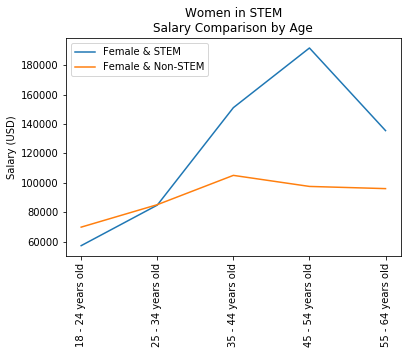

In [16]:
#Outputting a graph of women's salaries by age with and without a degree in a STEM area.

#Groupby removes nulls for Age, since we want to find STEM salaries by age bands, we don't want to impute these value.
#Otherwise, it may skew the distribution. Moreover, imputing salaries with the mean wouldn't have an impact as we're tryign to find the mean
df_STEM_age_f = df_female_grad.groupby(['STEM','Age']).ConvertedSalary.mean()['STEM'][working_professionals]
df_NSTEM_age_f = df_female_grad.groupby(['STEM','Age']).ConvertedSalary.mean()['Non-STEM'][working_professionals]


#Formatting and generating a graph
plt.plot(list(df_STEM_age_f.index),list(df_STEM_age_f), label='Female & STEM')
plt.plot(list(df_NSTEM_age_f.index),list(df_NSTEM_age_f), label='Female & Non-STEM')

plt.title("Women in STEM\nSalary Comparison by Age")
plt.ylabel('Salary (USD)')
plt.xticks(rotation=90)
plt.legend()

plt.savefig(os.path.join(os.getcwd(),'Female_STEM_Salary_by_age.png'),bbox_inches='tight')


As we can clearly see above, historically, STEM salaries have yielded higher paying professions, meaning that women's salary progression has been a harder battle due to the bias in their education.
However, there is optimism for the future as the trends in educational bias indicate that the gap between men and women are reducing and we are moving to a more equal society.

<h2 id='part1'>Additional material: Showcase Data prep, imputing values and ML techniques</h2>
 <br> I tried to incorporate machine learning / sklearn algorithms into my blog, however, the models produced did not give me sensible results. As a result, I've produced a framework for what I would have done if a model would have given me a sensible output.

In [17]:
#Showcase of data prep and evaluation for a machine learning (ML) model
#Splitting models into male and female since the data is skewed and is overfitting on male attributes.

#Converting variables which contain categorical data, into categorical variables (JobSatisfaction has been done above)
#Only doing for one dataframe as using this as a means to convert to floats for ML algorithm
df_male['CareerSatisfaction']=df_male['CareerSatisfaction']\
                                    .astype(pd.api.types.CategoricalDtype(
                                            categories=['Extremely dissatisfied','Moderately dissatisfied',
                                                        'Slightly dissatisfied','Neither satisfied nor dissatisfied',
                                                        'Slightly satisfied','Moderately satisfied','Extremely satisfied'],
                                            ordered=True))

df_male['CompanySize']=df_male['CompanySize']\
                                    .astype(pd.api.types.CategoricalDtype(
                                            categories=['Fewer than 10 employees','10 to 19 employees',
                                                        '20 to 99 employees','100 to 499 employees',
                                                        '500 to 999 employees','1,000 to 4,999 employees',
                                                        '5,000 to 9,999 employees','10,000 or more employees'],
                                            ordered=True))

df_male['Age']=df_male['Age']\
                                    .astype(pd.api.types.CategoricalDtype(
                                            categories=['Under 18 years old','18 - 24 years old', '25 - 34 years old',
                                                        '45 - 54 years old','35 - 44 years old', '55 - 64 years old',
                                                        '65 years or older'],
                                            ordered=True))


#Dropping Gender axis as this is not used, since we are creating a male and female model
df_male = df_male.drop(['Gender'], axis=1)
df_female = df_female.drop(['Gender'], axis=1)


#Adding flags for STEM and technical subjects, creating features from the analytics above (shown correlation between STEM & Salary)
#Dropping UndergradMajor as a result as engineered this feature from this.
#Making sure to distinguish the nulls so they aren't all classified as the wrong thing.
df_male['STEM'] = df_male['UndergradMajor'].apply(lambda x : [0] if x in non_STEM else [1,1 if pd.isna(x) else 0])
df_female['STEM'] = df_female['UndergradMajor'].apply(lambda x : [0] if x in non_STEM else [1,1 if pd.isna(x) else 0])
df_male['STEM'] = df_male['STEM'].apply(lambda x : np.nan if sum(x) == 2 else sum(x))
df_female['STEM'] = df_female['STEM'].apply(lambda x : np.nan if sum(x) == 2 else sum(x))

df_male['Technical'] = df_male['UndergradMajor'].apply(lambda x : [1] if x in technical_degree else [0, 2 if pd.isna(x) else 0])
df_female['Technical'] = df_female['UndergradMajor'].apply(lambda x : [1] if x in technical_degree else [0, 2 if pd.isna(x) else 0])
df_male['Technical'] = df_male['Technical'].apply(lambda x : np.nan if sum(x) == 2 else sum(x))
df_female['Technical'] = df_female['Technical'].apply(lambda x : np.nan if sum(x) == 2 else sum(x))

df_male = df_male.drop(['UndergradMajor'],axis=1)
df_female = df_female.drop(['UndergradMajor'],axis=1)


#Mapping 'Dependents' column to a flag, indicating whether or not the indiviual has children/dependents
dependent_mapping = {'Yes' : 1, 'No' : 0}

df_male['Dependents'] = df_male['Dependents'].apply(lambda x : dependent_mapping[x] if pd.isna(x) == False else x)
df_female['Dependents'] = df_female['Dependents'].apply(lambda x : dependent_mapping[x] if pd.isna(x) == False else x)


#Creating ordered lists of categorical variables so that they can be indexed, converting their original column into 
#I.e creating a numbered scale for example JobSatisfaction (1 being extremely dissatisfied to 7, extremely satisfied)
ordered_satisfaction = list(df_male.groupby('CareerSatisfaction').CareerSatisfaction.count().sort_index().index)
ordered_size = list(df_male.groupby('CompanySize').CompanySize.count().sort_index().index)
ordered_age = list(df_male.groupby('Age').CompanySize.count().sort_index().index)

df_male['CompanySize'] = df_male['CompanySize']\
                                .apply(lambda x : ordered_size.index(x) if pd.isna(x) == False else np.nan)
df_male['CareerSatisfaction'] = df_male['CareerSatisfaction']\
                                .apply(lambda x : ordered_satisfaction.index(x) if pd.isna(x) == False else np.nan)
df_male['JobSatisfaction'] = df_male['JobSatisfaction']\
                                .apply(lambda x : ordered_satisfaction.index(x) if pd.isna(x) == False else np.nan)
df_male['Age'] = df_male['Age']\
                                .apply(lambda x : ordered_age.index(x) if pd.isna(x) == False else np.nan)

df_female['CompanySize'] = df_female['CompanySize']\
                                .apply(lambda x : ordered_size.index(x) if pd.isna(x) == False else np.nan)
df_female['CareerSatisfaction'] = df_female['CareerSatisfaction']\
                                .apply(lambda x : ordered_satisfaction.index(x) if pd.isna(x) == False else np.nan)
df_female['JobSatisfaction'] = df_female['JobSatisfaction']\
                                .apply(lambda x : ordered_satisfaction.index(x) if pd.isna(x) == False else np.nan)
df_female['Age'] = df_female['Age']\
                                .apply(lambda x : ordered_age.index(x) if pd.isna(x) == False else np.nan)


#Showcasing another way to convert Age/YearsCoding columns to ML compatible inputs
#Taking the middle of the bands (i.e 0-2 years gets mapped to 1 year)
df_male['YearsCoding'] = df_male['YearsCoding']\
                                .apply(lambda x : sum([float(y) for y in x.split()[0].split('-')])/len(x.split()[0].split('-')) if pd.isna(x) == False else np.nan)
df_female['YearsCoding'] = df_female['YearsCoding']\
                                .apply(lambda x : sum([float(y) for y in x.split()[0].split('-')])/len(x.split()[0].split('-')) if pd.isna(x) == False else np.nan)


#Splitting out country columns into 11 columns, 1 for each top 10 most indicated  country and 1 for other.
#Placing a flag for each of the column, so if the country is United states, 1 would be in the united states column and 0 elsewhere
for frame in [df_male,df_female]:
    top_n_countries = list(frame.groupby('Country')['Country'].count().sort_values(ascending=False).nlargest(10).index)
    
    frame["Country_Other"] = frame['Country'].apply(lambda x : 0 if x in top_n_countries else 1)
    
    for value in top_n_countries:
        frame["Country_" + value] = frame['Country'].apply(lambda x : 1 if x == value else 0)


#Dropping the original Country column as the features ahve been extracted in a ML friendly manor        
df_male = df_male.drop(['Country'],axis=1)
df_female = df_female.drop(['Country'],axis=1)


The data has now been processed into a ML friendly format, except for the existence of nulls.

In [18]:
#Highlighting the nulls in each field
print('Male null %:\n',df_male.isnull().mean())
print('Female null %:\n',df_female.isnull().mean())

Male null %:
 CareerSatisfaction            0.059563
JobSatisfaction               0.135268
CompanySize                   0.218834
Age                           0.016275
ConvertedSalary               0.307201
YearsCoding                   0.000619
Dependents                    0.043941
STEM                          0.144969
Technical                     0.144969
Country_Other                 0.000000
Country_United States         0.000000
Country_India                 0.000000
Country_United Kingdom        0.000000
Country_Germany               0.000000
Country_Canada                0.000000
Country_Russian Federation    0.000000
Country_France                0.000000
Country_Brazil                0.000000
Country_Australia             0.000000
Country_Poland                0.000000
dtype: float64
Female null %:
 CareerSatisfaction            0.088682
JobSatisfaction               0.178499
CompanySize                   0.223407
Age                           0.024949
ConvertedSalary    

The above shows us what null values there are. There is a large proportion of the data which would be unusable if we were to just drop all na values. However, it wouldnt make sense to impute these values either as it would result in information lost.... 
<br>
<br> This could be as high as 34.8% (ConvertedSalary Female), but this would need to be dropped anyways as this is what we are fitting to. However, over 20% of the Company Size data is null and we can salvage some of the information from the rows with a null in Company size.

In [19]:
#Dropping nulls from the 6 columns listed below due to their strong correltions with salary.
#Converted Salarty is the column we are fitting against so this cannot be null, which is why we're dropping this.
df_male = df_male.dropna(subset=['ConvertedSalary'], axis=0)
df_female = df_female.dropna(subset=['ConvertedSalary'], axis=0)


#Converting categorical datatypes to float so we can allocate null values
df_male['CareerSatisfaction'] = df_male['CareerSatisfaction'].astype(str).astype(float)
df_male['JobSatisfaction'] = df_male['JobSatisfaction'].astype(str).astype(float)
df_male['CompanySize'] = df_male['CompanySize'].astype(str).astype(float)
df_male['Age'] = df_male['Age'].astype(str).astype(float)
df_female['CareerSatisfaction'] = df_female['CareerSatisfaction'].astype(str).astype(float)
df_female['JobSatisfaction'] = df_female['JobSatisfaction'].astype(str).astype(float)
df_female['Age'] = df_female['Age'].astype(str).astype(float)


#It wouldnt make sense to impute any of the values in these columns as it would confuse the correlations between variables.
#Using decision trees (random forest), putting in a negative value should distinguish these null values seperately
df_male = df_male.fillna(-1)
df_female = df_female.fillna(-1)


#Highlighting the nulls in each field
print('Male null %:\n',df_male.isnull().mean())
print('Female null %:\n',df_female.isnull().mean())

Male null %:
 CareerSatisfaction            0.0
JobSatisfaction               0.0
CompanySize                   0.0
Age                           0.0
ConvertedSalary               0.0
YearsCoding                   0.0
Dependents                    0.0
STEM                          0.0
Technical                     0.0
Country_Other                 0.0
Country_United States         0.0
Country_India                 0.0
Country_United Kingdom        0.0
Country_Germany               0.0
Country_Canada                0.0
Country_Russian Federation    0.0
Country_France                0.0
Country_Brazil                0.0
Country_Australia             0.0
Country_Poland                0.0
dtype: float64
Female null %:
 CareerSatisfaction            0.0
JobSatisfaction               0.0
CompanySize                   0.0
Age                           0.0
ConvertedSalary               0.0
YearsCoding                   0.0
Dependents                    0.0
STEM                          0.0
Tec

As you can now see, there are no more null values, therefore we can now fit a model to make predictions.
Since we want to predict salary, we will need a regressor as the data is continuos.

In [20]:
#Splitting the data into features and the varaible we want to predict
X_male = df_male.dropna().drop(['ConvertedSalary'],axis=1)
y_male = df_male.dropna()['ConvertedSalary']

X_female = df_female.dropna().drop(['ConvertedSalary'],axis=1)
y_female = df_female.dropna()['ConvertedSalary']


#Splitting data into train and test data
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_male,y_male,test_size=0.2,random_state=42)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_female,y_female,test_size=0.2,random_state=42)


#Training the random Forest model on the training set
clf_m = RandomForestRegressor(n_estimators=100)
clf_f = RandomForestRegressor(n_estimators=100)
clf_m.fit(X_train_m,y_train_m)
clf_f.fit(X_train_f,y_train_f)


#Making predictions off the model
y_pred_test_m=clf_m.predict(X_test_m)
y_pred_train_m=clf_m.predict(X_train_m)
y_pred_test_f=clf_f.predict(X_test_f)
y_pred_train_f=clf_f.predict(X_train_f)


#Evaluating the models performance
print("Male Test score: ",r2_score(y_test_m, y_pred_test_m))
print("Male Train score: ",r2_score(y_train_m, y_pred_train_m))
print("Female Test score: ",r2_score(y_test_f, y_pred_test_f))
print("Female Train score: ",r2_score(y_train_f, y_pred_train_f))

Male Test score:  -0.1647190095133353
Male Train score:  0.6343348094708942
Female Test score:  -0.352747888392694
Female Train score:  0.7641731028539402


The above example is a prime example of overfitting, taking features within a training dataset and creating correlations which improves their predictions, but, in fact, does not generalise well when dealing with new data. This is why the test score is so low but the training score is higher.

In [21]:
print("These are the male feature importances, ordered by importance:")
sorted(list(zip(X_male.columns,clf_m.feature_importances_)),key = lambda x:x[1],reverse=True)

These are the male feature importances, ordered by importance:


[('CompanySize', 0.1783631724501932),
 ('YearsCoding', 0.15839934490790603),
 ('JobSatisfaction', 0.15551956110043605),
 ('CareerSatisfaction', 0.15516283733941919),
 ('Age', 0.08583472587971956),
 ('Technical', 0.07202168967810567),
 ('Dependents', 0.0671682475935641),
 ('STEM', 0.043656818645698627),
 ('Country_United States', 0.04006003628349245),
 ('Country_Other', 0.00792933354986965),
 ('Country_United Kingdom', 0.007801654700393518),
 ('Country_Germany', 0.0059230102664078865),
 ('Country_Canada', 0.005367151314148302),
 ('Country_France', 0.00405081161812803),
 ('Country_Brazil', 0.003894001479764195),
 ('Country_Australia', 0.003317805382864355),
 ('Country_India', 0.003281244457385307),
 ('Country_Russian Federation', 0.0012063547566129966),
 ('Country_Poland', 0.0010421985958910713)]

In [22]:
print("These are the male feature importances, ordered by importance:")
sorted(list(zip(X_female.columns,clf_f.feature_importances_)),key = lambda x:x[1],reverse=True)

These are the male feature importances, ordered by importance:


[('YearsCoding', 0.19333074139290518),
 ('CompanySize', 0.19290305719238776),
 ('CareerSatisfaction', 0.16234651663749733),
 ('JobSatisfaction', 0.14951193529888887),
 ('Age', 0.08238100856729043),
 ('Technical', 0.06439333877457852),
 ('Dependents', 0.04532712189116471),
 ('STEM', 0.036917577019851634),
 ('Country_United States', 0.031930119672545845),
 ('Country_Other', 0.010383176966248854),
 ('Country_Canada', 0.008732562698830467),
 ('Country_United Kingdom', 0.00806812847779629),
 ('Country_Germany', 0.004441098344299977),
 ('Country_Australia', 0.0035376303064238897),
 ('Country_Netherlands', 0.002523256020543649),
 ('Country_India', 0.0013527382737290974),
 ('Country_France', 0.0013081788453115865),
 ('Country_Russian Federation', 0.0004104198395237776),
 ('Country_Poland', 0.000201393780182198)]